In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

import matplotlib_inline
import seaborn as sns
import pandas as pd

import flexibleSubsetSelection as fss

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
matplotlib_inline.backend_inline.set_matplotlib_formats('svg') # vector plots

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

from PIL import Image, ImageDraw

# Initialize notebook settings
sns.set_theme() # set seaborn theme
matplotlib_inline.backend_inline.set_matplotlib_formats('svg') # vector plots
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [5]:
titleSize = 16
labelSize = 14

# Load datasets from csv
socialMedia = pd.read_csv("../data/exampleDatasets/congressSocialMedia.csv")
ideology = pd.read_csv("../data/exampleDatasets/houseOnly116.csv")
photos = pd.read_csv("../data/exampleDatasets/congressPhotos.csv")

# Merge Twitter and Facebook follower counts
socialMedia.rename(columns={'Bioguide ID': 'bioguide'}, inplace=True)
socialMedia.rename(columns={'Max Total Followers': 'followers'}, inplace=True)
socialMedia = socialMedia.pivot_table(index=["bioguide"], 
                                      columns='Platform', 
                                      values='followers')

socialMedia = socialMedia.reset_index().fillna(0)
socialMedia['followers'] = socialMedia['facebook'] + socialMedia['twitter']
socialMedia = socialMedia.drop(columns=['facebook', 'twitter'])

# merge datasets
ideology.rename(columns={'bioguide_id': 'bioguide'}, inplace=True)
df = pd.merge(ideology, socialMedia, on='bioguide', how='inner')
df = pd.merge(df, photos, on='icpsr', how='inner')

# drop extra columns
dropCols = ["congress_x", "chamber_x", "state_icpsr", "last_means",
            "district_code", "state", "party_code", "occupancy", 
            "bioname", "born_x", "died_x", "conditional",
            "nominate_log_likelihood", "nominate_geo_mean_probability", 
            "nominate_number_of_votes", "nominate_number_of_errors", "source", 
            "provenance", "congress_y", "chamber_y",  "born_y",  "died_y"]
df.drop(inplace=True, columns=dropCols)
df.dropna(inplace=True)

df["name"] = df["name"].str.split(", ")
df["name"] = df["name"].apply(lambda x: " ".join(reversed(x)).title())

party_mapping = {
    "Democratic Party": "Democrat",
    "Republican Party": "Republican"
}
df["party"] = df["party"].map(party_mapping)

print(df)

FileNotFoundError: [Errno 2] No such file or directory: '../data/exampleDatasets/congressSocialMedia.csv'

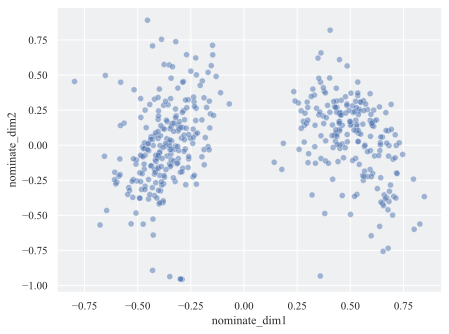

In [3]:
sns.scatterplot(data = df, 
        x = "nominate_dim1", 
        y = "nominate_dim2",
        alpha = 0.5);

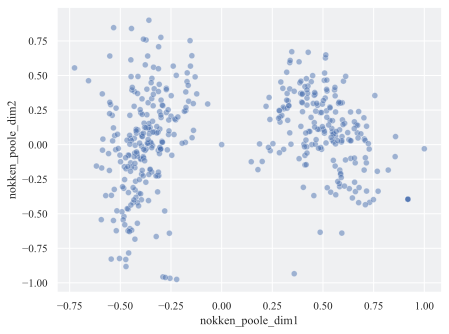

In [59]:
sns.scatterplot(data = df, 
        x = "nokken_poole_dim1", 
        y = "nokken_poole_dim2",
        alpha = 0.5);

In [60]:
features = ['nominate_dim1', 'nominate_dim2', "nokken_poole_dim1", "nokken_poole_dim2"]
cluster_range = range(5, 21)

silhouette_scores = []
cluster_labels = []
kmeans_models = []

# Loop through each cluster count
for n_clusters in cluster_range:
    # Apply KMeans with current cluster count
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df[features])
    
    # Get cluster labels and compute silhouette score
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(df[features], labels)
    
    silhouette_scores.append(silhouette_avg)
    cluster_labels.append(labels)
    kmeans_models.append(kmeans)

# Find the optimal number of clusters
optimal_index = np.argmax(silhouette_scores)
optimal_cluster_count = cluster_range[optimal_index]
optimal_cluster_labels = cluster_labels[optimal_index]
optimal_kmeans_model = kmeans_models[optimal_index]

# Assign the optimal cluster labels to the dataframe
df["cluster"] = optimal_cluster_labels

# Calculate distances to the cluster centers and add to the dataframe
df['centerDist'] = np.min(cdist(df[features], optimal_kmeans_model.cluster_centers_), axis=1)


In [61]:
features = ["followers", "centerDist"]

dataset = sets.Dataset(data=df, 
                       features=features, 
                       categorical="cluster",
                       bins=5)

z, timeTotal, loss = approximation.greedySwap(dataset, 
                                              s=optimal_cluster_count, 
                                              objective=objectives.maxAndCenter)

subset = sets.Subset(dataset, z, length=optimal_cluster_count)
print(loss)

122.58945030867538 -12.35295 -400 -289.7634996913246
121.19437379209141 -11.91244 -300 -190.71806620790858
129.31157403411643 -11.81847 -300 -182.5068959658836
121.66608215830921 -1.51273 -300 -179.8466478416908
128.68595403365865 -12.33736 -400 -283.6514059663414
123.29277545833364 -12.35295 -400 -289.06017454166636
112.92797476668869 -12.80386 -400 -299.8758852333113
121.04517500871373 -12.26938 -300 -191.22420499128629
113.39968313290652 -1.96364 -300 -188.56395686709348
120.41955500825594 -12.33299 -400 -291.91343499174405
115.02637643293092 -12.80386 -400 -297.7774835670691
160.1854445088678 -12.02185 -300 -151.8364054911322
158.64116920890615 -12.37879 -300 -153.73762079109386
150.99567733309894 -2.07305 -300 -151.07737266690106
158.01554920844836 -12.91327 -400 -254.89772079155165
152.62237063312335 -12.91327 -400 -260.29089936687666
118.98208562446109 -12.30732 -300 -193.3252343755389
117.43781032449942 -13.19874 -400 -295.76092967550056
109.7923184486922 -2.35852 -300 -192.566

In [62]:
def crop_to_circle(image, zoom):
    width, height = image.size
    square_size = min(width, height)
    zoomed_square_size = int(square_size / zoom)
    
    # Calculate the new cropping box, centered horizontally and from the top
    left = (width - zoomed_square_size) // 2
    upper = 20
    right = left + zoomed_square_size
    lower = upper + zoomed_square_size
    
    # Crop to the new zoomed square
    zoomed_square_image = image.crop((left, upper, right, lower))
    
    # Create circular mask
    mask = Image.new('L', (zoomed_square_size, zoomed_square_size), 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((0, 0, zoomed_square_size, zoomed_square_size), fill=255)
    
    # Apply circular mask to the image
    circular_image = Image.new('RGBA', (zoomed_square_size, zoomed_square_size))
    circular_image.paste(zoomed_square_image, (0, 0), mask=mask)
    return circular_image

In [63]:
# Settings
x="nominate_dim1"
y="nominate_dim2"
scale = 0.09
zoom = 1.4
palette = [color["green"], color["yellow"], color["orange"], color["blue"], color["darkGreen"]]

/var/folders/g7/k2wgq3hd4_7crzw88nqrqdv80000gn/T/ipykernel_49442/365848719.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("congress.pdf", bbox_inches="tight")
/Users/cbbcbail/Documents/GitHub/flexibleSubsetSelector/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


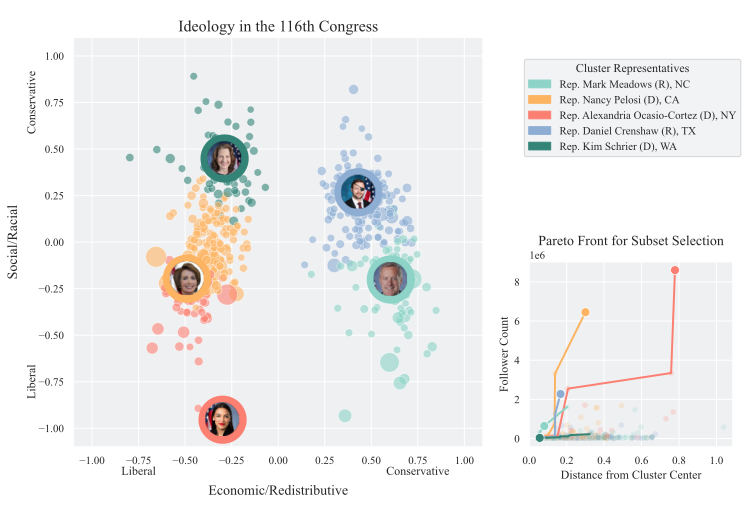

In [64]:
fig = plt.figure(figsize=(10.5, 7))  # Adjust the figure size as needed
grid = GridSpec(nrows=2, ncols=3, figure=fig)
ax1 = fig.add_subplot(grid[:, 0:2])
ax2 = fig.add_subplot(grid[1:, 2:])

sns.scatterplot(data=df, 
                x=x, 
                y=y, 
                hue = "cluster", 
                palette  =palette, 
                size = "followers",
                sizes = (50, 2000),
                alpha = 0.6,
                ax=ax1)

sns.scatterplot(data = subset.df,
                x = x, 
                y = y, 
                hue = "cluster", 
                palette = palette,
                s = 2000,
                edgecolor = None,
                ax=ax1)

for index, row in subset.df.iterrows(): 
    image_path = row['image']
    image = Image.open("datasets/" + image_path)
    circular_image = np.array(crop_to_circle(image, zoom))

    x = row['nominate_dim1']
    y = row['nominate_dim2']
    ax1.imshow(circular_image, 
               extent=(x - scale, x + scale, y - scale, y + scale), 
               alpha=1,
               zorder=1)

ax1.set_title('Ideology in the 116th Congress', fontsize=titleSize)
ax1.set_xlabel('\nEconomic/Redistributive', fontsize=labelSize)
ax1.set_ylabel('Social/Racial\n', fontsize=labelSize)
ax1.set_xlim([-1.1, 1.1])
ax1.set_ylim([-1.1, 1.1])
ax1.get_legend().remove()

sort = subset.df.sort_values(by="cluster")
labels = [f"Rep. {name} ({party[0]}), {state}" for name, party, state in zip(sort["name"], sort["party"], sort["state_abbrev"])]

legend_markers = [
    mpatches.Circle((0.1, 0.1), 0.1, color=palette[i]) for i in range(len(subset.df["cluster"]))
]

# Create a separate axis for the legend
legend_ax = fig.add_axes([0.8, 0.6, 0.1, 0.4])
legend_ax.axis('off')
legend_ax.legend(handles=legend_markers, 
                 labels=labels, 
                 title='Cluster Representatives', 
                 loc='center')

ax1.text(-0.75, -1.25, "Liberal", ha="center", )
ax1.text(0.75, -1.25, "Conservative", ha="center")

ax1.text(-1.35, -0.75, "Liberal", va="center", rotation=90)
ax1.text(-1.35, 0.75, "Conservative", va="center", rotation=90)

pareto_front_data = []
for i, cluster_label in enumerate(subset.df["cluster"]):
    # Filter data for the current cluster
    cluster_mask = dataset.df["cluster"] == cluster_label
    cluster_centerDist = dataset.df["centerDist"][cluster_mask]
    cluster_followers = dataset.df["followers"][cluster_mask]

    # Sort data by increasing 'centerDist'
    sorted_indices = np.argsort(cluster_centerDist)
    sorted_centerDist = cluster_centerDist.iloc[sorted_indices]
    sorted_followers = cluster_followers.iloc[sorted_indices]

    # Initialize variables for Pareto front
    pareto_front_centerDist = [sorted_centerDist.iloc[0]]
    pareto_front_followers = [sorted_followers.iloc[0]]

    # Iterate through the sorted data to find Pareto front
    for j in range(1, len(sorted_centerDist)):
        if sorted_followers.iloc[j] > pareto_front_followers[-1]:
            pareto_front_centerDist.append(sorted_centerDist.iloc[j])
            pareto_front_followers.append(sorted_followers.iloc[j])

    # Plot the Pareto front for the current cluster
    ax2.plot(pareto_front_centerDist, 
             pareto_front_followers, 
             color=palette[cluster_label],
             lw=2)

sns.scatterplot(data=dataset.df, 
                x="centerDist", 
                y="followers", 
                hue="cluster",
                ax=ax2,
                palette=palette,
                alpha=0.2)

sns.scatterplot(data=subset.df, 
                x="centerDist", 
                y="followers", 
                hue="cluster",
                ax=ax2,
                palette=palette,
                s=80,
                zorder=2)

ax2.set_title('Pareto Front for Subset Selection', fontsize=labelSize)
ax2.set_xlabel('Distance from Cluster Center')
ax2.set_ylabel('Follower Count')
ax2.get_legend().remove()

plt.subplots_adjust()
plt.savefig("congress.pdf", bbox_inches="tight")

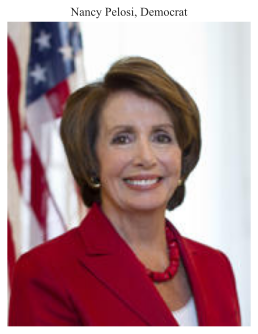

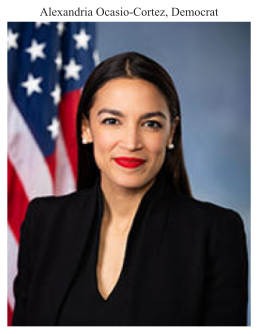

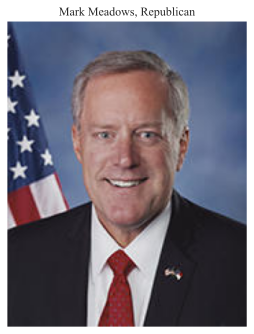

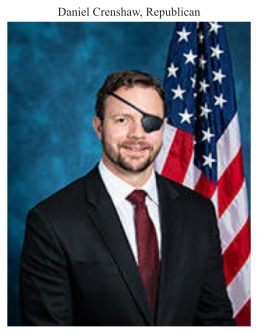

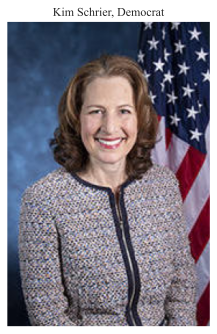

In [65]:
for index, row in subset.df.iterrows():  # Use head() to limit to 5 rows for demonstration
    # Get the image file path from the 'image' column
    image_path = row['image']
    
    # Load and display the image using matplotlib
    image = Image.open("datasets/" + image_path)
    plt.imshow(image)
    plt.title(f"{row['name']}, {row['party']}")
    plt.axis('off')  # Turn off axis
    plt.show()


<Axes: xlabel='centerDist', ylabel='followers'>

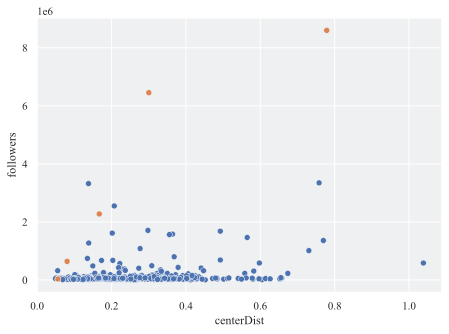

In [66]:
sns.scatterplot(data=dataset.df, x="centerDist", y="followers")
sns.scatterplot(data=subset.df, x="centerDist", y="followers")